In [50]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [51]:
df = pd.read_csv('/content/monthly_wind_energy_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [52]:
df.head()

,Power Generated
Date,
2003-01-01,111.39170
2003-02-01,68.21788
2003-03-01,30.83054
2003-04-01,33.19830
2003-05-01,173.93480


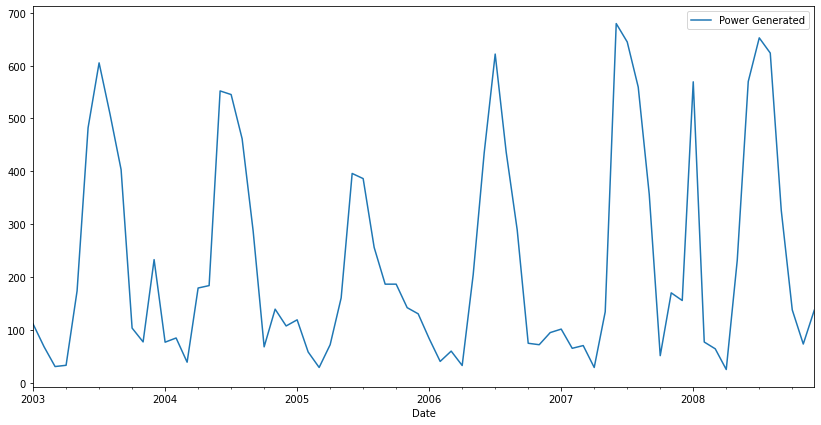

In [53]:
df.plot(figsize=(14,7))

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

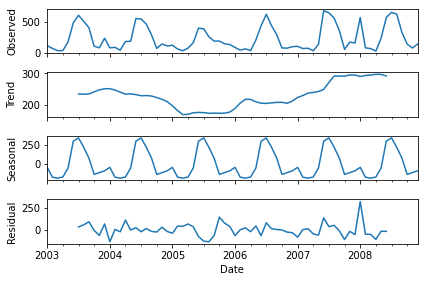

In [55]:
results = seasonal_decompose(df['Power Generated'])
results.plot();

In [56]:
len(df)

72

In [57]:
train = df.iloc[:60]
test = df.iloc[60:]

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [59]:
df.head(),df.tail()

(            Power Generated
 Date                       
 2003-01-01        111.39170
 2003-02-01         68.21788
 2003-03-01         30.83054
 2003-04-01         33.19830
 2003-05-01        173.93480,             Power Generated
 Date                       
 2008-08-01        623.71961
 2008-09-01        326.13679
 2008-10-01        137.93206
 2008-11-01         73.42393
 2008-12-01        137.44138)

In [60]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [61]:
scaled_train[:10]

array([[0.12655115],
       [0.0601698 ],
       [0.00268537],
       [0.00632589],
       [0.2227135 ],
       [0.69721593],
       [0.8857203 ],
       [0.73576199],
       [0.57523788],
       [0.11456051]])

In [62]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [63]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [64]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.12655115 0.0601698  0.00268537]
Predict this y: 
 [[0.00632589]]


In [65]:
X.shape

(1, 3, 1)

In [66]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [67]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [68]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [70]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
48/48 [==============================] - 1s 6ms/step - loss: 0.1066
Epoch 2/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0846
Epoch 3/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0815
Epoch 4/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0721
Epoch 5/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0533
Epoch 6/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0528
Epoch 7/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 8/50
48/48 [==============================] - 0s 7ms/step - loss: 0.0321
Epoch 9/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0351
Epoch 10/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0560
Epoch 11/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0329
Epoch 12/50
48/48 [==============================] - 0s 6ms/step - loss: 0.0265
Epoch 13/50
48/48 [==============================

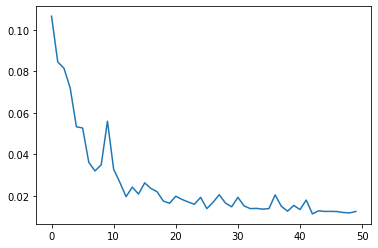

In [71]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [72]:
last_train_batch = scaled_train[-12:]

In [73]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [74]:
model.predict(last_train_batch)

array([[0.09091324]], dtype=float32)

In [75]:
scaled_test[0]

array([0.83062822])

In [76]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [77]:
test_predictions

[array([0.09091324], dtype=float32),
 array([0.07156935], dtype=float32),
 array([0.06053982], dtype=float32),
 array([0.05919482], dtype=float32),
 array([0.14908594], dtype=float32),
 array([0.77386004], dtype=float32),
 array([0.85720676], dtype=float32),
 array([0.7416545], dtype=float32),
 array([0.46376073], dtype=float32),
 array([0.1735661], dtype=float32),
 array([0.15460835], dtype=float32),
 array([0.11530956], dtype=float32)]

In [78]:
test.head()

,Power Generated
Date,
2008-01-01,569.31692
2008-02-01,77.20500
2008-03-01,64.36373
2008-04-01,25.24633
2008-05-01,231.98313


In [79]:
true_predictions = scaler.inverse_transform(test_predictions)

In [80]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


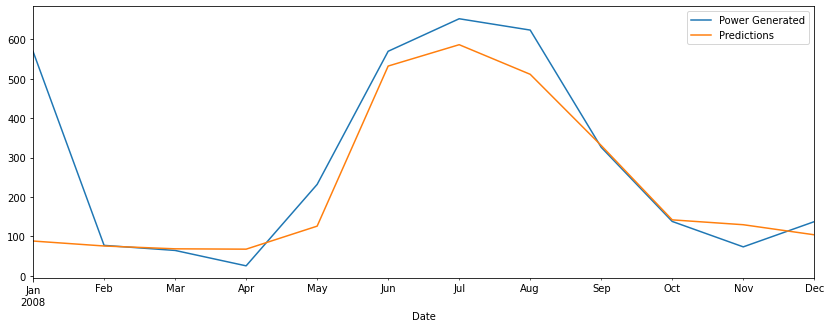

In [81]:
test.plot(figsize=(14,5))

In [82]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Power Generated'],test['Predictions']))
print(rmse)

149.20746293654824
